# NLP Project: Sentiment Analysis with Word2Vec (Part 2)

** The Word2Vec model is a simple word embedding neural network, developed by Mikolov et al. (2013).**
* Such **continuous word embedding representations** have have been proven to be able to carry **semantic meanings** and are useful in various NLP tasks.
* The model assumes the **Distributional Hypothesis** that words are characterized by other words in their **vicinity**.
* This idea is used to estimate the **probability of two words occurring near each other**.

In [16]:
from numpy import average
import os
import gensim
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# Load JSON File

In [3]:
import graphlab as gl
gl.canvas.set_target('ipynb')
#gl.canvas.set_target('browser')

def load_json_from_file(filename):
    """
    Load JSON from a file.
    INPUT:  filename  Name of the file to be read.
    RETURN: Output SFrame
    """
    # Read the entire file into a SFrame with one row
    sf = gl.SFrame.read_csv(filename, delimiter='\n', header=False)
    
    # The dictionary can be unpacked to generate the individual columns.
    sf = sf.unpack('X1', column_name_prefix='')
    return sf

In [9]:
Sport = load_json_from_file('/Users/marvinbertin/Desktop/data/Sport_sentiment')

PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/Sport_sentiment
PROGRESS: Parsing completed. Parsed 100 lines in 0.706755 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 113078 lines. Lines per second: 76301.5
PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/Sport_sentiment
PROGRESS: Parsing completed. Parsed 768312 lines in 6.16828 secs.


# Sport Review Dataset

In [12]:
Sport

overall,reviewText,sentiment,summary
5,I love this chair forusing at my computer. ...,1,Great chair
2,My Kindergartener usesthis lock to secure her ...,0,Falls apart and getsstuck ...
2,Such a let down! I triedto use this mat last ...,0,So slippery!
2,I was looking forward tousing this. The Picture ...,0,Too Bad
5,Purchased my first fullcarbon bike and was told ...,1,Great Tool
4,I got these for my 5 yearold daughter and she ...,1,Big Hit with my Daughter
2,"If I receive wat I askfor, I don't like it too ...",0,Wasn't wat i wan't
5,"quality is not very good,but it's good enough for ...",1,good enough
2,"In the description itsays it fits a 48"" waist ...",0,"48"" waist? I think not"
5,"This Watch is Sharp!, itlooks a lot like a Watch ...",1,Worth Every Penny in TheGold Box ...


## Example of a review

In [10]:
Sport['reviewText'][0]

"I love this chair for using at my computer.  It's the second one I've bought from Amazon and I've gotten many comments from friends who see it.  I just have to make myself not lean against the back so it does what it's purported to do - help your posture!"

# Combine All The Reviews Into One File

In [131]:
BASE_DIR = "/Users/marvinbertin/Desktop/data"

In [17]:
mashed = "\n".join(Sport['reviewText'])
with open(os.path.join(BASE_DIR, "txt/sportsReviews.txt"), "w") as f:
    f.write(mashed)

# Parse Text Into Sentences

In [133]:
class TrainSentences(object):
    """
    Iterator class that returns Sentences from texts files in a input directory
    """
    RE_WIHTE_SPACES = re.compile("\s+")
    STOP_WORDS = set(stopwords.words("english"))
    
    def __init__(self, filename):
        """
        Initialize a TrainSentences object with a input filename that contains text files for training
        :param filename: file name which contains the text       
        """
        self.filename = filename

    def __iter__(self):
        """
        Sentences iterator that return sentences parsed from files in the input directory.
        Each sentences is returned as list of words
        """
        # read line from file (Without reading the entire file)
        for line in file(self.filename, "r"):
            # split the read line into sentences using NLTK
            for sent in txt2sentences(line):
                # split the sentence into words using regex
                w =txt2words(sent,
                             lower=True,
                             remove_stop_words=False,
                             remove_none_english_chars=True)
                
                #skip short sentences with less than 3 words
                if len(w) < 3:
                    continue
                yield w

## Use NLTK's Punkt Sentence Tokenizer

In [34]:
def txt2sentences(txt, remove_none_english_chars=True):
    """
    Split the English text into sentences using NLTK
    :param txt: input text.
    :param remove_none_english_chars: if True then remove non-english chars from text
    :return: string in which each line consists of single sentence from the original input text.
    :rtype: str
    """
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    # split text into sentences using nltk packages
    for s in tokenizer.tokenize(txt):
        if remove_none_english_chars:
            #remove none English chars
            s = re.sub("[^a-zA-Z]", " ", s)
        yield s

## Make Every Sentence a List of Words

In [36]:
def txt2words(txt, lower=True, remove_none_english_chars=True, remove_stop_words=True):
    """
    Split text into words list
    :param txt: the input text
    :param lower: if to make the  text to lowercase or not.
    :param remove_none_english_chars: if True then remove non-english chars from text
    :param remove_stop_words: if True then remove stop words from text
    :return: words list create from the input text according to the input parameters.
    :rtype: list
    """
    if lower:
        txt = txt.lower()
    if remove_none_english_chars:
        txt = re.sub("[^a-zA-Z]", " ", txt)

    words = TrainSentences.RE_WIHTE_SPACES.split(txt.strip().lower())
    
    if remove_stop_words:
        #remove stop words from text
        words = [w for w in words if w not in TrainSentences.STOP_WORDS]
    return words

# Train Word2Vect

In [47]:
sentences = TrainSentences(os.path.join(BASE_DIR, "txt/sportsReviews.txt"))

In [48]:
model_Sport = gensim.models.Word2Vec(sentences,
                                     size=300,
                                     min_count=40,
                                     window=8)
model_Sport.save(os.path.join(BASE_DIR ,"sport_300_c_40_w_8.word2vec"))

# Explore Embedded Words

In [49]:
model_Sport.most_similar("terrific")

[('fantastic', 0.7145101428031921),
 ('great', 0.6555029153823853),
 ('wonderful', 0.6375762224197388),
 ('fabulous', 0.5946256518363953),
 ('phenomenal', 0.5340671539306641),
 ('excellent', 0.5293058156967163),
 ('superb', 0.514076828956604),
 ('awesome', 0.5106169581413269),
 ('outstanding', 0.5017399191856384),
 ('amazing', 0.48741185665130615)]

In [50]:
model_Sport.most_similar("horrible")

[('terrible', 0.8401502370834351),
 ('awful', 0.6961092948913574),
 ('horrid', 0.5938861966133118),
 ('atrocious', 0.5628483295440674),
 ('lousy', 0.5514189004898071),
 ('horrendous', 0.5308316946029663),
 ('pathetic', 0.5148214101791382),
 ('dreadful', 0.4818209409713745),
 ('aweful', 0.4583595097064972),
 ('horrific', 0.44951626658439636)]

# Fun Analogies

In [180]:
predict = model_Sport.most_similar_cosmul(positive=['king', 'man'], negative=['queen'])[0]
print "king - queen + man = {}".format(predict[0])

king - queen + man = woman


In [169]:
predict = model_Sport.most_similar_cosmul(positive=['running', 'ski'], negative=['run'])[0]
print " running - run + ski = {}".format(predict[0])

 running - run + ski = skiing


In [176]:
predict = model_Sport.most_similar_cosmul(positive=['cheapest', 'cool'], negative=['cheap'])[0]
print " cheapest - cheap + cool = {}".format(predict[0])

 cheapest - cheap + cool = coolest


# Find the Intruder

In [177]:
model_Sport.doesnt_match(['skiing', 'swimming', 'climbing', 'sleeping'])

'sleeping'

In [179]:
model_Sport.doesnt_match(['hand', 'head', 'foot', 'hair'])

'hair'

# Word Embedding Visualization

Word 'horrible' and 'terrible' have high similarity: 0.84


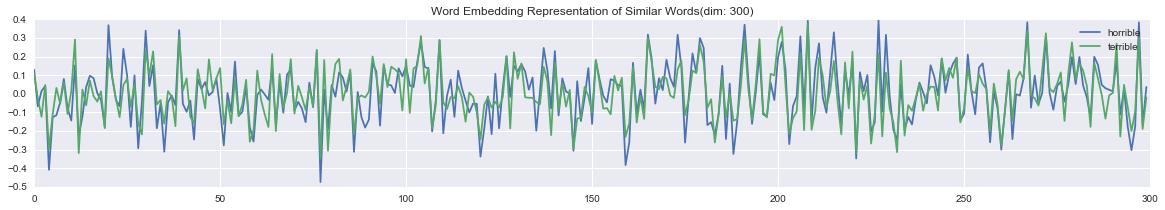

In [196]:
print "Word 'horrible' and 'terrible' have high similarity: {:.2f}".format(model_Sport.similarity('horrible', 'terrible'))

plt.figure(figsize=(20, 3))
plt.plot(range(300), model_Sport['horrible'])
plt.plot(range(300), model_Sport['terrible'])
plt.legend(['horrible', 'terrible'])
plt.title('Word Embedding Representation of Similar Words(dim: 300)')
plt.show()

Word 'potato' and 'love' have low similarity: 0.01


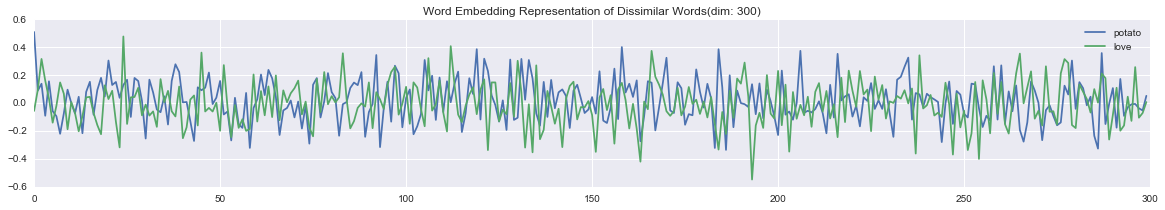

In [199]:
print "Word 'potato' and 'love' have low similarity: {:.2f}".format(model_Sport.similarity('potato', 'love'))

plt.figure(figsize=(20, 3))
plt.plot(range(300), model_Sport['potato'])
plt.plot(range(300), model_Sport['love'])
plt.legend(['potato', 'love'])
plt.title('Word Embedding Representation of Dissimilar Words(dim: 300)')
plt.show()

# Word2Vec Sentiment Analysis
** The DeepTextAnalyzer vectorizes the words in a review and averages them in one vector embedding**

In [51]:
class DeepTextAnalyzer(object):
    def __init__(self, word2vec_model):
        """
        Construct a DeepTextAnalyzer using the input Word2Vec model
        :param word2vec_model: a trained Word2Vec model
        """
        self._model = word2vec_model

    def txt2vectors(self,txt):
        """
        Convert input text into an iterator that returns the corresponding vector representation of each
        word in the text, if it exists in the Word2Vec model
        :param txt: input text
        :return: iterator of vectors created from the words in the text using the Word2Vec model.
        """
        words = txt2words(txt, lower=True, remove_none_english_chars=True)
        words = [w for w in words if w in self._model]
        if len(words) != 0:
            for w in words:
                yield self._model[w]


    def txt2avg_vector(self, txt):
        """
        Calculate the average vector representation of the input text
        :param txt: input text
        :return the average vector of the vector representations of the words in the text  
        """
        vectors = self.txt2vectors(txt)
        vectors_sum = next(vectors, None)
        if vectors_sum is None:
            return None
        count =1.0
        for v in vectors:
            count += 1
            vectors_sum = np.add(vectors_sum,v)
        
        #calculate the average vector and replace +infy and -inf with numeric values 
        avg_vector = np.nan_to_num(vectors_sum/count)
        return avg_vector

# Review2Vect

In [52]:
dt = DeepTextAnalyzer(model_Sport)
Sport['vectors'] = Sport['reviewText'].apply(lambda r: dt.txt2avg_vector(r))

In [57]:
Sport.head()

overall,reviewText,sentiment,summary,vectors
5,I love this chair forusing at my computer. ...,1,Great chair,"[0.0256419274956,0.00641404185444, ..."
2,My Kindergartener usesthis lock to secure her ...,0,Falls apart and getsstuck ...,"[-0.091676287353,-0.0490146353841, ..."
2,Such a let down! I triedto use this mat last ...,0,So slippery!,"[-0.0615132041276,0.0257563963532, ..."
2,I was looking forward tousing this. The Picture ...,0,Too Bad,"[0.079170294106,-0.059742808342, ..."
5,Purchased my first fullcarbon bike and was told ...,1,Great Tool,"[-0.0305297728628,-0.0285292342305, ..."
4,I got these for my 5 yearold daughter and she ...,1,Big Hit with my Daughter,"[0.0216339249164,0.0514854006469, ..."
2,"If I receive wat I askfor, I don't like it too ...",0,Wasn't wat i wan't,"[0.0299516189843,0.0517501458526, ..."
5,"quality is not very good,but it's good enough for ...",1,good enough,"[0.0457096733153,0.0367940254509, ..."
2,"In the description itsays it fits a 48"" waist ...",0,"48"" waist? I think not","[0.00452239252627,0.0481718108058, ..."
5,"This Watch is Sharp!, itlooks a lot like a Watch ...",1,Worth Every Penny in TheGold Box ...,"[-0.00142007833347,0.0489712171257, ..."


# Logisitc Classifier with Embedded Review Vectors

In [62]:
Sport, Nas = Sport.dropna_split()

In [63]:
Sport_train, Sport_test = Sport.random_split(0.8, seed = 0)

In [64]:
# Automatically take validation set for tuning
word2vec_model = gl.logistic_classifier.create(Sport_train[['sentiment', 'vectors']],
                                                  target = 'sentiment',
                                                  features=['vectors'], 
                                                  l2_penalty=0.01,
                                                  max_iterations = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 583285
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 300
PROGRESS: Number of coefficients    : 301
PROGRESS: Starting Newton Method
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 2        | 360.740921   | 0.851105          | 0.851924            |
PROGRESS: | 2         | 3        | 538.984012 

In [65]:
def print_statistics(result):
    print "*" * 30
    print "Accuracy        : ", result["accuracy"]
    print "Precision       : ", result['precision']
    print "Recall          : ", result['recall']
    print "AUC             : ", result['auc']
    print "Confusion Matrix: \n", result["confusion_matrix"]

In [68]:
result_word2vec = word2vec_model.evaluate(Sport_test)
print_statistics(result_word2vec)

******************************
Accuracy        :  0.854770809266
Precision       :  0.855807793237
Recall          :  0.867044556752
AUC             :  0.929505492319
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        | 11649 |
|      0       |        0        | 61823 |
|      1       |        1        | 69139 |
|      1       |        0        | 10602 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



In [71]:
word2vec_model.show(view = 'Evaluation')

** what to note:**
* word2vec model performed close to the Unigram model
* However this performance was achieved with just 300 features (as opposed to 4 million!)
* Averaging the word vectors removes ordering and adds unnecessary noise

** Maybe performing word2vec on the review summary would give better result. We saw previously that the review summary where more signal dense**

# Review Summary
** Let's train the review summary just like we trained the review. Since sentences are shorter and we have less text to train on, the word embedding was reduced to 200 features, the window to 5 and the minimum word count to 20**

In [132]:
mashed = "\n".join(Sport['summary'])
with open(os.path.join(BASE_DIR, "txt/sportsSummary.txt"), "w") as f:
    f.write(mashed)

In [134]:
sent_Summary = TrainSentences(os.path.join(BASE_DIR, "txt/sportsSummary.txt"))

In [135]:
model_Sport_Summary = gensim.models.Word2Vec(sent_Summary,
                                     size=200,
                                     min_count=20,
                                     window=5)
model_Sport_Summary.save(os.path.join(BASE_DIR ,"sportSummary_200_c_30_w_5.word2vec"))

# Explore Embedded Words
** Despite the limited corpus the word embedding seems decent**

In [138]:
model_Sport_Summary.most_similar('horrible')

[('terrible', 0.8657429218292236),
 ('awful', 0.8092228770256042),
 ('lousy', 0.7548978328704834),
 ('horrid', 0.7292232513427734),
 ('aweful', 0.7017415761947632),
 ('unacceptable', 0.6918298006057739),
 ('pathetic', 0.6916425228118896),
 ('rude', 0.6912922263145447),
 ('horrendous', 0.690521776676178),
 ('abysmal', 0.6828699111938477)]

In [137]:
model_Sport_Summary.most_similar("terrific")

[('excelent', 0.7967259287834167),
 ('wonderful', 0.7929089069366455),
 ('fantastic', 0.792600154876709),
 ('outstanding', 0.7820264101028442),
 ('great', 0.7681150436401367),
 ('incredible', 0.7647918462753296),
 ('excellent', 0.7497338056564331),
 ('fabulous', 0.7480643391609192),
 ('excellant', 0.7264809608459473),
 ('superb', 0.7246178984642029)]

# Train Logistice Classifier on Review Summary

In [139]:
dt = DeepTextAnalyzer(model_Sport_Summary)
Sport['vectorsSummary'] = Sport['summary'].apply(lambda r: dt.txt2avg_vector(r))

In [140]:
Sport, Nas = Sport.dropna_split()

In [141]:
Sport_train, Sport_test = Sport.random_split(0.8, seed = 0)

In [142]:
# Automatically take validation set for tuning
word2vec_model = gl.logistic_classifier.create(Sport_train[['sentiment', 'vectorsSummary']],
                                                  target = 'sentiment',
                                                  features=['vectorsSummary'], 
                                                  l2_penalty=0.01,
                                                  max_iterations = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 573096
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 200
PROGRESS: Number of coefficients    : 201
PROGRESS: Starting Newton Method
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 2        | 155.606620   | 0.807762          | 0.810881            |
PROGRESS: | 2         | 3        | 238.616211 

In [144]:
result2_word2vec = word2vec_model.evaluate(Sport_test)
print_statistics(result2_word2vec)

******************************
Accuracy        :  0.807441860465
Precision       :  0.809527966577
Recall          :  0.825652832013
AUC             :  0.886673937275
Confusion Matrix: 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        | 15273 |
|      0       |        0        | 56608 |
|      1       |        0        | 13707 |
|      1       |        1        | 64912 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



** What to note:**
* Same weaknesses as full review word2vec
* Review summaries are too short to allow word2vect to learn more complex language structure

** In this notebook, we learned that word2vec is able to learn nice structures in language. For example, words can be manipulated with arithmetic operations.**

**We also learned that averaging word vectors to represent a review is not more powerful than a simple Bag of Word model.**

**So in what context would word2vec be more powerful?**

## [PART 3: Document Classification](http://nbviewer.jupyter.org/github/MarvinBertin/Deep-NLP-Project/blob/master/NLP%20Project%20-%20Deep%20Inverse%20Classifier%20%28PART%203%29.ipynb)